In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

data = pd.read_csv("../resources/data/Sleep_health_and_lifestyle_dataset.csv")

data["Gender"].value_counts()

Gender
Male      189
Female    185
Name: count, dtype: int64

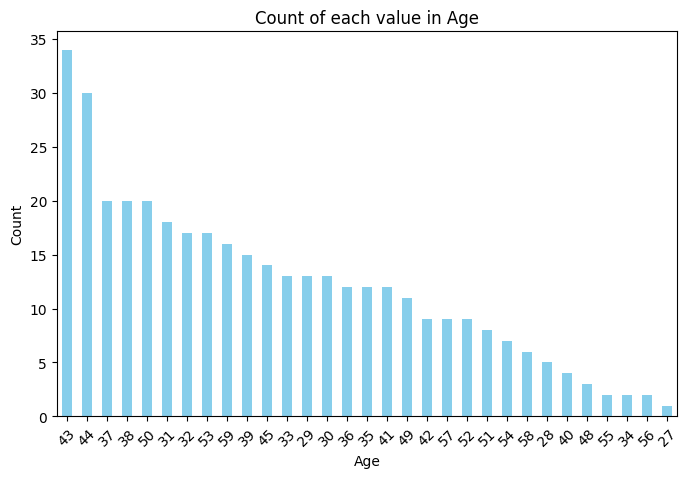

In [33]:
def plot_column_counts(data: DataFrame, column: str):
    counts = data[column].value_counts()
    plt.figure(figsize=(8, 5))
    counts.plot(kind='bar', color='skyblue')
    plt.title(f'Count of each value in {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()

plot_column_counts(data, "Age")


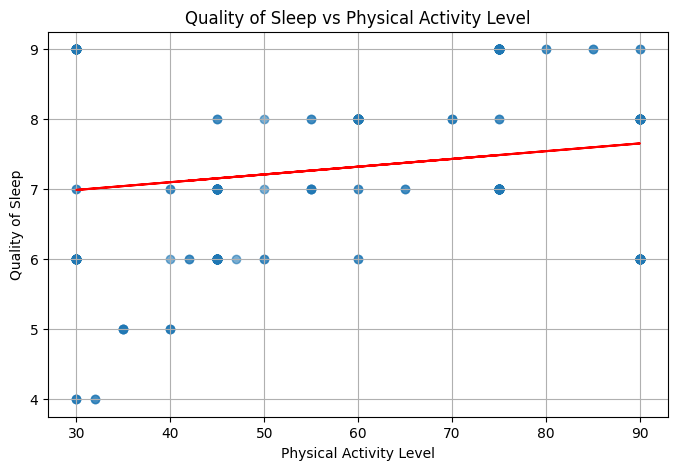

In [34]:
def plot_scatter(data: DataFrame, x_col: str, y_col: str, range = 0.6):
    #Procesar la información antes de mostrarla en caso de outliers. 
    values_x = data[x_col]
    values_y = data[y_col]
    x_low, x_high = values_x.quantile(0.5-range/2), values_x.quantile(0.5+range/2)
    y_low, y_high = values_y.quantile(0.5-range/2), values_y.quantile(0.5+range/2)
    mask = (values_x >= x_low) & (values_x <= x_high) & (values_y >= y_low) & (values_y <= y_high)
    filtering = data[mask]

    plt.figure(figsize=(8, 5))
    plt.scatter(filtering[x_col], filtering[y_col], alpha=0.6)

    values_x = filtering[x_col]
    values_y = filtering[y_col]
    coeffs = np.polyfit(values_x, values_y, 1)
    fit_line = np.poly1d(coeffs)
    plt.plot(values_x, fit_line(values_x), color='red', label='Linea de mejor ajuste')
    plt.title(f'{y_col} vs {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.grid(True)
    plt.show()


plot_scatter(data, 'Physical Activity Level', 'Quality of Sleep', 1)

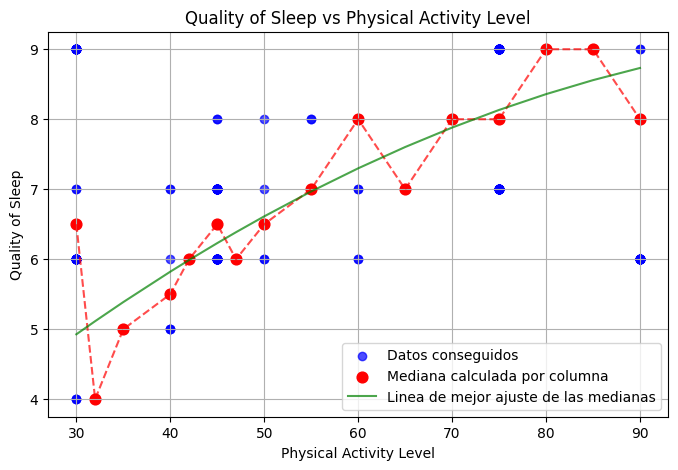

In [41]:
# Plot all non-outlier points, and overlay the median per x value

def plot_points_and_grouped_median(data: DataFrame, x_col: str, y_col: str, lower=0.00, upper=1):
    # Exclude outliers in y_col for each x_col group, but keep all non-outlier points
    filtered_points_x = []
    filtered_points_y = []
    medians = []
    x_vals = []
    grouped = data.groupby(x_col)
    for x_val, group in grouped:
        y = group[y_col]
        y_low, y_high = y.quantile(lower), y.quantile(upper)
        y_filtered = y[(y >= y_low) & (y <= y_high)]
        if not y_filtered.empty:
            filtered_points_x.extend([x_val]*len(y_filtered))
            filtered_points_y.extend(y_filtered)
            x_vals.append(x_val)
            medians.append(y_filtered.median())
    plt.figure(figsize=(8, 5))
    plt.scatter(filtered_points_x, filtered_points_y, color='blue', alpha=0.7, label='Datos conseguidos')
    plt.scatter(x_vals, medians, color='red', s=60, label='Mediana calculada por columna')
    plt.plot(x_vals, medians, color='red', linestyle='--', alpha=0.7)

    coeffs = np.polyfit(x_vals, medians, 2)
    fit_line = np.poly1d(coeffs)
    plt.plot(x_vals, fit_line(x_vals), color='green', alpha=0.7, label = 'Linea de mejor ajuste de las medianas')
    plt.title(f'{y_col} vs {x_col}')
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage:
plot_points_and_grouped_median(data, 'Physical Activity Level', 'Quality of Sleep', lower=0, upper=1)


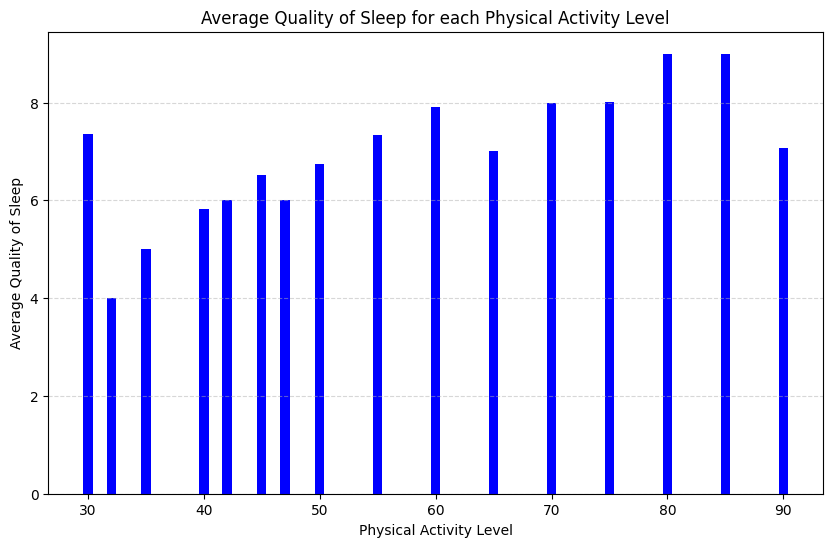

In [42]:
# Bar graph: average Quality of Sleep for each Physical Activity Level

def bar_avg_by_group(data: DataFrame, x_col: str, y_col: str):
    avg = data.groupby(x_col)[y_col].mean().reset_index()
    plt.figure(figsize=(10, 6))
    plt.bar(avg[x_col], avg[y_col], color='blue')
    plt.xlabel(x_col)
    plt.ylabel(f'Average {y_col}')
    plt.title(f'Average {y_col} for each {x_col}')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()

# Example usage:
bar_avg_by_group(data, 'Physical Activity Level', 'Quality of Sleep')


In [8]:
def create_bins_and_display(data: DataFrame, column: str, n: int):
    """
    Create bins for a numerical column and display the bin ranges.

    Parameters:
        data (DataFrame): The dataset containing the column.
        column (str): The name of the column to bin.
        n (int): The number of bins to create.
    """
    # Get unique values and sort them
    unique_values = sorted(data[column].unique())
    
    # Divide unique values into n equal bins
    bins = pd.cut(unique_values, bins=n, retbins=True, labels=False)[1]

    # Display the bins
    print("=== Bins for column '{}' ===".format(column))
    for i in range(len(bins) - 1):
        print(f"Bin {i + 1}: {bins[i]:.2f} to {bins[i + 1]:.2f}")
    return bins

# Example usage:
create_bins_and_display(data, 'Physical Activity Level', n=5)

def sleep_vs_physical_activity_report(data):

    bins = create_bins_and_display(data, 'Physical Activity Level', n=4)

    # Create labels for the bins
    labels = []
    for i in range(len(bins) - 1):
        labels.append(f"{bins[i]:.2f}-{bins[i+1]:.2f}")

    # Group data by bins
    data["Physical Activity Level grouped"] = pd.cut(
        data['Physical Activity Level'],
        bins=bins,
        labels=labels,
        include_lowest=True,
        right=True
    )

    # Calculate means
    promedios = data.groupby("Physical Activity Level grouped", observed=False)["Quality of Sleep"].mean()

    tabla = promedios.reset_index().rename(columns={"Quality of Sleep": "Avg Quality of Sleep"})
    # Calculate counts
    conteos = data["Physical Activity Level grouped"].value_counts().sort_index()

    # Create the report
    print("=== Reporte: Calidad de sueño por cantidad de ejercicio ===\n")
    for grupo, promedio in promedios.items():
        cantidad = conteos[grupo]
        print(f"- Grupo {grupo}: promedio = {promedio:.2f} (n={cantidad})")

    # Automatic observations (optional)
    mejor = promedios.idxmax()
    peor = promedios.idxmin()

    print(f"\nEl grupo con mejor calidad de sueño es {mejor}, "
          f"mientras que el grupo con peor calidad de sueño es {peor}.")

sleep_vs_physical_activity_report(data)

=== Bins for column 'Physical Activity Level' ===
Bin 1: 29.94 to 42.00
Bin 2: 42.00 to 54.00
Bin 3: 54.00 to 66.00
Bin 4: 66.00 to 78.00
Bin 5: 78.00 to 90.00
=== Bins for column 'Physical Activity Level' ===
Bin 1: 29.94 to 45.00
Bin 2: 45.00 to 60.00
Bin 3: 60.00 to 75.00
Bin 4: 75.00 to 90.00
=== Reporte: Calidad de sueño por cantidad de ejercicio ===

- Grupo 29.94-45.00: promedio = 6.79 (n=150)
- Grupo 45.00-60.00: promedio = 7.79 (n=81)
- Grupo 60.00-75.00: promedio = 7.99 (n=72)
- Grupo 75.00-90.00: promedio = 7.18 (n=71)

El grupo con mejor calidad de sueño es 60.00-75.00, mientras que el grupo con peor calidad de sueño es 29.94-45.00.


In [3]:
def create_bins_and_display(data: DataFrame, column: str, n: int):
    """
    Create bins for a numerical column and display the bin ranges.

    Parameters:
        data (DataFrame): The dataset containing the column.
        column (str): The name of the column to bin.
        n (int): The number of bins to create.
    """
    # Get unique values and sort them
    unique_values = sorted(data[column].unique())
    
    # Divide unique values into n equal bins
    bins = pd.cut(unique_values, bins=n, retbins=True, labels=False)[1]

    # Display the bins
    print("=== Bins for column '{}' ===".format(column))
    for i in range(len(bins) - 1):
        print(f"Bin {i + 1}: {bins[i]:.2f} to {bins[i + 1]:.2f}")

# Example usage:
create_bins_and_display(data, 'Physical Activity Level', n=5)

=== Bins for column 'Physical Activity Level' ===
Bin 1: 29.94 to 42.00
Bin 2: 42.00 to 54.00
Bin 3: 54.00 to 66.00
Bin 4: 66.00 to 78.00
Bin 5: 78.00 to 90.00
